In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import os

# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Function to smooth only the throughput data using rolling mean
def smooth_throughput(df, window_size=1):
    df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    return df

# Create directory if it doesn't exist
output_dir = 'work_dealing_stealing'
os.makedirs(output_dir, exist_ok=True)
    
df = pd.read_csv("results_nebulastream_concat.csv")
df['normalized_timestamp'] = df['normalized_timestamp'] / 1000
df

,normalized_timestamp,query_id,throughput,bufferSizeInBytes,buffersInGlobalBufferManager,executionMode,joinStrategy,numberOfEntriesSliceCaches,numberOfWorkerThreads,pageSize,query,resourceAssignment,sliceCacheType
0,0.0,1,1040000.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,agg,WORK_STEALING,LRU
1,0.5,1,1143000.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,agg,WORK_STEALING,LRU
2,1.0,1,1193000.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,agg,WORK_STEALING,LRU
3,1.5,1,1601000.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,agg,WORK_STEALING,LRU
4,2.0,1,1600000.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,agg,WORK_STEALING,LRU
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015055,1965.5,53,189542.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,LRU
1015056,1965.5,54,255030.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,LRU
1015057,1965.5,55,237394.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,LRU
1015058,1965.5,56,222506.0,8196,4000000,COMPILER,HASH_JOIN,10,8,4096,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,LRU


In [5]:
n = 300
df_sum_temp = df[df['normalized_timestamp'] < n]

df_sum_temp = df_sum_temp[df_sum_temp['query'] == 'filter']
df_sum_temp = df_sum_temp.groupby(['normalized_timestamp', 'resourceAssignment', 'query']).sum(numeric_only=True).reset_index()
df_sum_temp.to_csv('df_sum_temp.csv')

/tmp/ipykernel_53163/889857414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


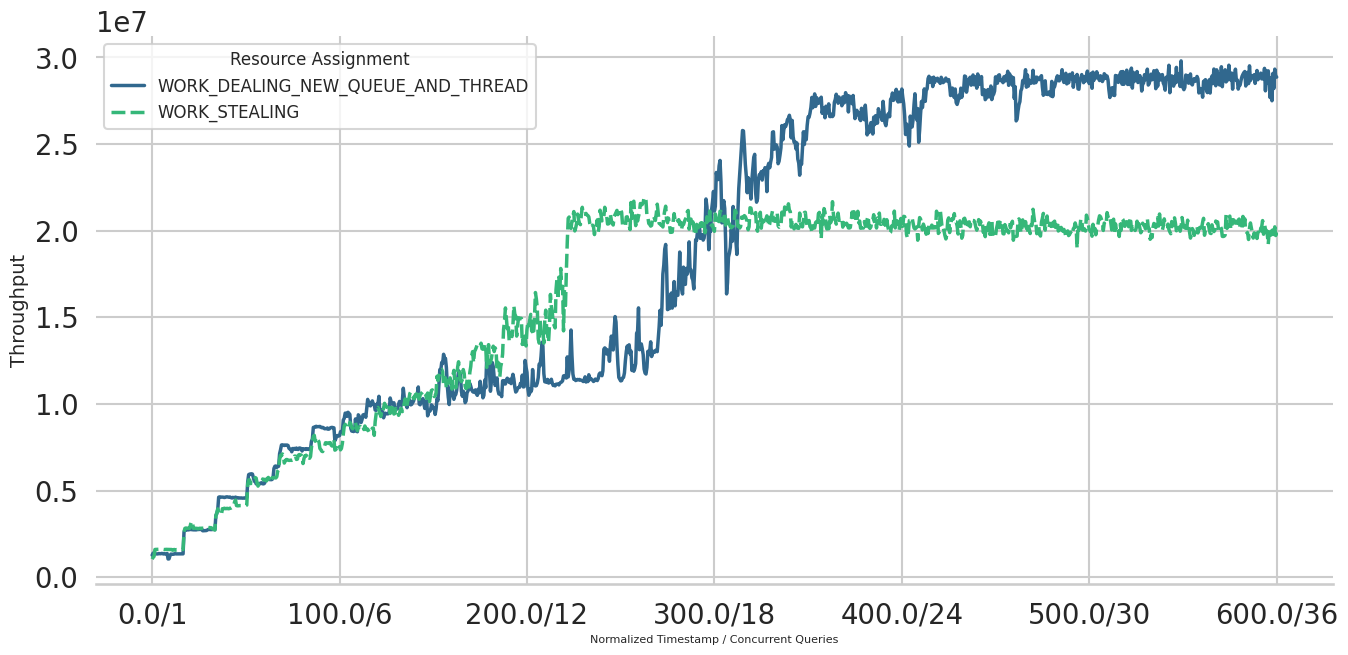

/tmp/ipykernel_53163/889857414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


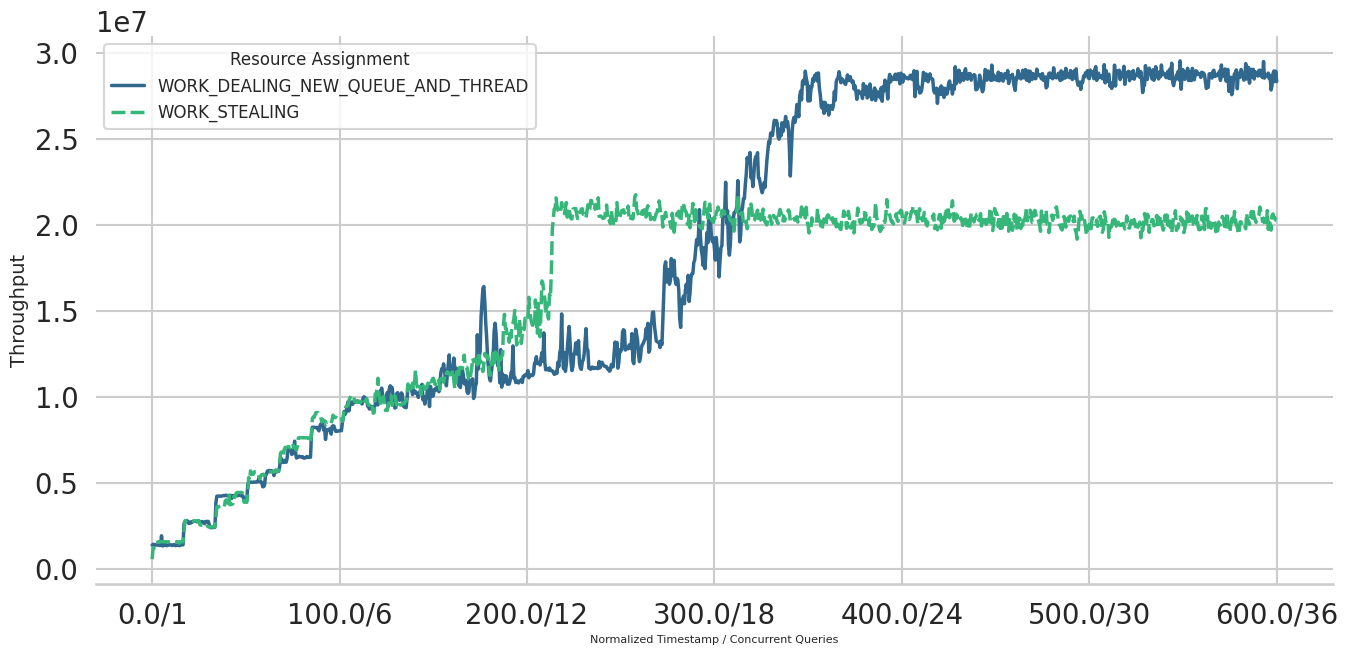

In [3]:
# Only keep timestamps smaller than n
n = 600
df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_timestamp', 'resourceAssignment']).sum(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_throughput(query_df)

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', hue='resourceAssignment', style='resourceAssignment', palette='viridis', linewidth=2.5)

    ## Add vertical lines at the first occurrence of each query_id
    #for timestamp in first_timestamps:
    #    plt.axvline(x=timestamp, color='gray', linestyle='--', alpha=0.7)

    # Customize x-axis ticks to show every 5th timestamp and concurrent query count
    unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
    step = 200
    plt.xticks(ticks=unique_timestamps[::step],
               labels=[f"{ts}/{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
                       for ts in unique_timestamps[::step]],
               rotation=0, ha='center')

    #plt.title(f'Throughput over Time for {query} (Sum of All Query IDs)', fontsize=16, fontweight='bold')
    plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=8)
    plt.ylabel('Throughput', fontsize=14)
    plt.legend(title='Resource Assignment', title_fontsize=12, fontsize=12)
    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_fix_equal_ingestion_rate.pdf'))
    plt.show()

In [4]:
%%script echo skipping
# Plot 2: Each query separately (hue: query_id) but separate plots per resource assignment and per query
resource_assignments = df['resourceAssignment'].unique()

for resource in resource_assignments:
    for query in queries:
        plt.figure(figsize=(14, 7))
        resource_query_df = df[(df['resourceAssignment'] == resource) & (df['query'] == query)]
        smoothed_df = smooth_throughput(resource_query_df)
        ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', hue='query_id', style='query_id', palette='magma', linewidth=2.5)

        ## Customize x-axis ticks to show every 5th timestamp and concurrent query count
        #unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
        #step = 200
        #plt.xticks(ticks=unique_timestamps[::step],
        #           labels=[f"{ts}\n{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
        #                   for ts in unique_timestamps[::step]],
        #           rotation=45, ha='right')

        plt.title(f'Throughput over Time for {resource} - {query}', fontsize=16, fontweight='bold')
        plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=14)
        plt.ylabel('Throughput', fontsize=14)
        plt.legend(title='Query ID', title_fontsize=12, fontsize=12)
        sns.despine(left=True)
        plt.tight_layout()
        plt.show()

skipping
